In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from pandas import IndexSlice as idx
import geopandas as gpd
import os



In [51]:
data_dir = '/cluster/tufts/hugheslab/datasets/bird/asurv/asurv-gps-data/gps'
data_dir = '/cluster/home/kheuto01/code/data_for_bird_forecasting/gps/2009_to_2018_monthly_500M'
gps_path = os.path.join(data_dir, 'gps_2009_to_2018.csv')
gps_path = os.path.join(data_dir, 'gps_2009_to_2018_monthly_500M_clipped.csv')
df = pd.read_csv(gps_path)

In [52]:
df.groupby(['lat', 'long']).sum().shape

(12576, 3)

In [53]:
# make a column with a unique integer ID for every different lat lon combination
df['lat_lon_id'] = df.groupby(['lat', 'long']).ngroup()

In [54]:
df['lat_lon_id'].max()

12575

In [55]:
# make a column with a unique integer ID for every different lat lon combination
df['month_id'] = df.groupby(['month_name']).ngroup()

In [5]:
# make a column with a unique integer ID for every different value of the 'geometry' column
df['geometry_id'] = df['geometry'].factorize()[0]

KeyError: 'geometry'

In [10]:
# assert that id's are functionally equivalent
assert df.lat_lon_id.nunique() == df.geometry_id.nunique()
# assert that the size of each individual group of each index is the same
assert all(df.groupby('lat_lon_id').size() == df.groupby('geometry_id').size())

AttributeError: 'DataFrame' object has no attribute 'geometry_id'

In [56]:
# drop geometry column
#df = df.drop(columns='geometry')
# rename an id to 'geoid', drop the other one
df = df.rename(columns={'lat_lon_id': 'geoid'})#.drop(columns='lat_lon_id')
# rename week_id to timestep
df = df.rename(columns={'month_id': 'timestep'})
# set index on geoid and timestep  and make a column called timestep with the same value
df = df.set_index(['geoid', 'timestep']).assign(timestep=lambda x: x.index.get_level_values('timestep')).sort_index()

(1358208, 14)

In [57]:
# create columns that contain the previous count values in this geoid for the prior 10 weeks, filling with 0 if no value exists
for i in range(1, 11):
    df[f'count_lag_{i}'] = df.groupby('geoid')['counts'].shift(i).fillna(0)

In [58]:
# find geoid and timestep with largest count
max_count = df['counts'].idxmax()
max_count_geoid = max_count[0]
max_count_timestep = max_count[1]


In [59]:
max_count_timestep

72

In [60]:
# show lags ahead of the max count and prove they match
print(df.loc[max_count_geoid, 72])

counts                             311.0
month_name      2015-11-30_to_2015-12-31
lat                            28.187425
long                          -96.866061
timestep                              72
count_lag_1                         65.0
count_lag_2                         13.0
count_lag_3                          0.0
count_lag_4                          0.0
count_lag_5                          0.0
count_lag_6                          0.0
count_lag_7                          0.0
count_lag_8                         57.0
count_lag_9                        125.0
count_lag_10                        12.0
Name: (3326, 72), dtype: object


<Axes: xlabel='timestep'>

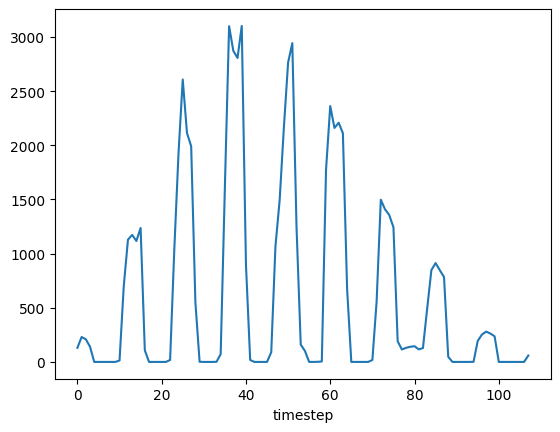

In [61]:
#plot total counts by timestep index
timestep_counts = df.rename(columns={'timestep':'t1'}).groupby('timestep')['counts'].sum()
timestep_counts.plot()

In [39]:
timestep_counts[333]

KeyError: 333

In [62]:
train_timesteps = list(range(1, 35))
val_timesteps = list(range(35, 42))
test_timesteps = list(range(42, 70))

In [63]:
# drop weekname column
df = df.drop(columns='month_name')

In [64]:
geoids = sorted(df.index.get_level_values('geoid').unique())

In [65]:
len(geoids)

12576

In [67]:
# save train, val, test data
# no counts in X files
# counts only in y files
df.loc[idx[:, train_timesteps], :].drop(columns='counts').to_csv('bird_train_x.csv')
df.loc[idx[:, train_timesteps], 'counts'].to_csv('bird_train_y.csv')
df.loc[idx[:, val_timesteps], :].drop(columns='counts').to_csv('bird_valid_x.csv')
df.loc[idx[:, val_timesteps], 'counts'].to_csv('bird_valid_y.csv')
df.loc[idx[:, test_timesteps], :].drop(columns='counts').to_csv('bird_test_x.csv')
df.loc[idx[:, test_timesteps], 'counts'].to_csv('bird_test_y.csv')

In [66]:
# get unique geoids from df
geoids = df.index.get_level_values('geoid').unique()
len(geoids)

12576

In [2]:
def load_xy_splits(
        data_dir = os.environ.get('DATA_DIR'),
        timescale='year',
        csv_pattern_str='cook_county_gdf_cleanwithsvi_{timescale}.csv',
        timestep_col='timestep',
        geography_col='geoid',
        outcome_col='deaths',
        year_col='year',
        context_size_in_tsteps=3,
        train_years=[2017, 2018, 2019],
        valid_years=[2020],
        test_years=[2021, 2022],
        space_cols=LATLON_COLS,
        svi_cols=SVI_COLS,
        add_space=True,
        add_time=True,
        add_svi=True,
        **kwargs
        ):
    all_df = gpd.read_file(os.path.join(
        data_dir, csv_pattern_str.format(timescale=timescale)))

    x_cols_only = []
    if add_space:
        x_cols_only += space_cols
    if add_time:
        x_cols_only += [timestep_col]
    if add_svi:
        x_cols_only += svi_cols
    y_cols_only = ['deaths']
    info_cols_only = [year_col]

    # Create the multiindex, reinserting timestep as a col not just index
    all_df = all_df.astype({geography_col: int, timestep_col: int})
    mi_df = all_df.set_index([geography_col, timestep_col])
    mi_df[timestep_col] = mi_df.index.get_level_values(timestep_col)

    x_df = mi_df[x_cols_only].copy()
    y_df = mi_df[y_cols_only].copy()
    info_df = mi_df[info_cols_only].copy()

    tr_years = np.sort(np.unique(np.asarray(train_years)))
    va_years = np.sort(np.unique(np.asarray(valid_years)))
    te_years = np.sort(np.unique(np.asarray(test_years)))
    assert np.max(tr_years) < np.min(va_years)
    assert np.max(va_years) < np.min(te_years)
    W = int(context_size_in_tsteps)

    kws = dict(timestep_col=timestep_col,
        year_col=year_col, outcome_col=outcome_col, 
        **kwargs)
    tr_tup = make_x_y_i_data_with_filled_context(
        x_df, y_df, info_df, tr_years[0], tr_years[-1], W, **kws)
    va_tup = make_x_y_i_data_with_filled_context(
        x_df, y_df, info_df, va_years[0], va_years[-1], W, **kws)
    te_tup = make_x_y_i_data_with_filled_context(
        x_df, y_df, info_df, te_years[0], te_years[-1], W, **kws)

    return tr_tup, va_tup, te_tup

def make_outcome_history_feat_names(W, outcome_col='deaths'):
    return ['prev_%s_%02dback' % (outcome_col, W - ww) for ww in range(W)]

def make_x_y_i_data_with_filled_context(
        x_df, y_df, info_df,
        first_year, last_year,
        context_size_in_tsteps,
        lag_in_tsteps=1,
        how_to_handle_tstep_without_enough_context='raise_error',
        year_col='year', timestep_col='timestep', outcome_col='deaths'):
    """ Create x,y,i dataframes suitable for supervised learning

    Fill in features in x corresponding to previously seen y vals as context

    Args
    ----
    x_df
    y_df
    info_df
    first_year : int
        The first year to make predictions for
    last_year : int
        The final year (inclusive) to make predictions for
        Can be the same as first_year
    window_size_in_tsteps : int
        How many timesteps of data prior to the prediction tstep to include
    lag_in_tsteps : int
        The number of timesteps between the outcome y and the inputs x. 
        For example, if you want 3-step-ahead predictions
    year_col (str): The name of the column containing the year
    timestep_col (str): The neame of the temporal index level
    outcome_col (str): Name of column with outcome variable (deaths) we are trying to predict

    Returns
    -------
    x_df : dataframe with shape (N, F)
        Each entry is a valid covariate for predicting y in corresp row
    y_df : dataframe with shape (N, 1)
    i_df : dataframe with shape (N, K)
        Holds "info" columns corresponding to rows in x,y
    """
    first_year = int(first_year)
    last_year = int(last_year)
    assert last_year >= first_year
    
    L = int(lag_in_tsteps)
    W = int(context_size_in_tsteps)
    new_col_names = make_outcome_history_feat_names(W)

    xs = []
    ys = []
    infos = []

    # Iterate over years we want to make predictions for
    for eval_year in range(first_year, last_year + 1):

        t_index = info_df[info_df[year_col] == eval_year].index
        timesteps_in_year = t_index.unique(level=timestep_col).values
        timesteps_in_year = np.sort(np.unique(timesteps_in_year))
        
        for tt, tstep in enumerate(timesteps_in_year):
            # Make per-tstep dataframes
            x_tt_df = x_df.loc[idx[:, tstep], :].copy()
            y_tt_df = y_df.loc[idx[:, tstep], :].copy()
            info_tt_df = info_df.loc[idx[:, tstep], :].copy()

            # Determine if we can get a full window of 'actual' data, or if we need to zero-pad
            if tstep - (W + L - 1) <= 0:
                if how_to_handle_tstep_without_enough_context == 'raise_error':
                    raise ValueError("Not enough context available for tstep %d. Need at least %d previous tsteps" % (tstep, W+L-1))
                assert how_to_handle_tstep_without_enough_context == 'pad_with_zero'
                WW = tstep - L
            else:
                WW = W
            # Grab current tstep's history from outcomes at previous tsteps
            xhist_N = y_df.loc[idx[:, tstep-(WW+L-1):(tstep-L)], outcome_col].values.copy()
            N = xhist_N.shape[0]
            M = N // WW
            xhist_MW = xhist_N.reshape((M, WW))
            if WW < W:
                xhist_MW = np.hstack([ np.zeros((M, W-WW)), xhist_MW])
            assert xhist_MW.shape[1] == W
            for ww in range(W):
                x_tt_df[new_col_names[ww]] = xhist_MW[:, ww]
                
            xs.append(x_tt_df)
            ys.append(y_tt_df)
            infos.append(info_tt_df)

    return  DataSet(pd.concat(xs), pd.concat(ys), pd.concat(infos))

In [5]:
tr, va, te = load_xy_splits(
    data_dir = '/cluster/tufts/hugheslab/datasets/NSF_OD/results_202308_pipeline',
    timescale='annual',
    csv_pattern_str='clean_{timescale}_tract',
    train_years=range(2005, 2018+1),
    valid_years=[2019],
    test_years=[2020, 2021],
    context_size_in_tsteps=10,
    how_to_handle_tstep_without_enough_context='pad_with_zero',
    svi_cols=['theme_1_pc', 'theme_2_pc', 'theme_3_pc',
                    'theme_4_pc', 'svi_pctile'],
    space_cols=['lat', 'lon'],
    timestep_col='timestep',
    add_space=True,
    add_time=True,
    add_svi=True)

In [8]:
tr[0].to_csv('mass_train_x.csv')
tr[1].to_csv('mass_train_y.csv')

va[0].to_csv('mass_valid_x.csv')
va[1].to_csv('mass_valid_y.csv')

te[0].to_csv('mass_test_x.csv')
te[1].to_csv('mass_test_y.csv')

In [7]:
tr[1]

,,deaths
geoid,timestep,
25001010100,5,2.0
25001010206,5,0.0
25001010208,5,0.0
25001010304,5,0.0
25001010306,5,0.0
...,...,...
25027761100,18,1.0
25027761200,18,0.0
25027761300,18,0.0


In [ ]:
# get unique geoids
geoids = tr[0].index.get_level_values('geoid').unique()